In [61]:
import requests
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [62]:
countryName = 'Italy'

In [63]:
# For each competition in a country, fetch all clubs in the competition. Then, for each club, fetch all it's players
competitions = requests.get(f'http://localhost:8080/sql/competitions/country/{countryName}').json()
data = np.array([])
for competition in competitions:
    id = competition['competitionId']
    clubs = requests.get(f'http://localhost:8080/mongo/games/competition/{id}/clubs').json()
    for club in clubs:
        response = requests.get(f'http://localhost:8080/sql/players/club/{club}').json()
        data = np.hstack((data, response))

players_df = pd.DataFrame.from_records(data)

# Make dataset lighter
players_df = players_df.drop(columns=['currentClubId', 'playerCode', 'contractExpirationDate', 'agentName', 'imageUrl', 'url', 'currentClubDomesticCompetitionId', 'currentClubId', 'currentClubName', 'currentClubId', 'playerCode', 'countryOfCitizenship', 'foot'])

In [64]:
# Calculate player's age and remove players with undefined data
players_df['dateOfBirth'] = pd.to_datetime(players_df['dateOfBirth'])
current_date = datetime.now()
players_df['age'] = np.floor((current_date - players_df['dateOfBirth']) / pd.Timedelta('365 days'))

players_df = players_df.dropna(subset=['marketValueInEur', 'age', 'lastSeason'])
players_df.reset_index(inplace=True)

In [65]:
# Get only active players, so that marketValueInEur value is accurate to player's age 
players_df = players_df.query('lastSeason == 2023')
players_df

,index,id,firstName,lastName,playerName,lastSeason,countryOfBirth,cityOfBirth,dateOfBirth,subPosition,position,heightInCm,marketValueInEur,highestMarketValueInEur,age
0,0,82442,Olivier,Giroud,Olivier Giroud,2023,France,Chambéry,1986-09-30,Centre-Forward,Attack,192.0,4000000.0,27000000.0,37.0
1,1,700998,Chaka,Traorè,Chaka Traorè,2023,Cote d'Ivoire,Attecoube,2004-12-23,Left Winger,Attack,175.0,500000.0,500000.0,19.0
2,2,257462,Luka,Jović,Luka Jović,2023,Bosnia-Herzegovina,Bijeljina,1997-12-23,Centre-Forward,Attack,182.0,8000000.0,60000000.0,26.0
3,3,351816,Ismaël,Bennacer,Ismaël Bennacer,2023,France,Arles,1997-12-01,Defensive Midfield,Midfield,175.0,38000000.0,40000000.0,26.0
4,4,339808,Theo,Hernández,Theo Hernández,2023,France,Marseille,1997-10-06,Left-Back,Defender,184.0,60000000.0,60000000.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,6401,169880,Giovanni,Di Lorenzo,Giovanni Di Lorenzo,2023,Italy,Castelnuovo di Garfagnana,1993-08-04,Right-Back,Defender,183.0,25000000.0,25000000.0,30.0
4739,6402,405885,Giacomo,Raspadori,Giacomo Raspadori,2023,Italy,Bentivoglio,2000-02-18,Second Striker,Attack,172.0,35000000.0,35000000.0,23.0
4740,6403,250683,Nikita,Contini,Nikita Contini,2023,Ukraine,Cherkasy,1996-05-21,Goalkeeper,Goalkeeper,190.0,500000.0,800000.0,27.0
4741,6404,257732,Amir,Rrahmani,Amir Rrahmani,2023,Yugoslavia (Republic),Prishtinë,1994-02-24,Centre-Back,Defender,192.0,25000000.0,25000000.0,29.0


In [66]:
# Categorize players into 'Foreigners' and 'Locals'
players_df['type'] = players_df['countryOfBirth'].apply(lambda x: 'Foreigner' if x != countryName else 'Local')
players_df

,index,id,firstName,lastName,playerName,lastSeason,countryOfBirth,cityOfBirth,dateOfBirth,subPosition,position,heightInCm,marketValueInEur,highestMarketValueInEur,age,type
0,0,82442,Olivier,Giroud,Olivier Giroud,2023,France,Chambéry,1986-09-30,Centre-Forward,Attack,192.0,4000000.0,27000000.0,37.0,Foreigner
1,1,700998,Chaka,Traorè,Chaka Traorè,2023,Cote d'Ivoire,Attecoube,2004-12-23,Left Winger,Attack,175.0,500000.0,500000.0,19.0,Foreigner
2,2,257462,Luka,Jović,Luka Jović,2023,Bosnia-Herzegovina,Bijeljina,1997-12-23,Centre-Forward,Attack,182.0,8000000.0,60000000.0,26.0,Foreigner
3,3,351816,Ismaël,Bennacer,Ismaël Bennacer,2023,France,Arles,1997-12-01,Defensive Midfield,Midfield,175.0,38000000.0,40000000.0,26.0,Foreigner
4,4,339808,Theo,Hernández,Theo Hernández,2023,France,Marseille,1997-10-06,Left-Back,Defender,184.0,60000000.0,60000000.0,26.0,Foreigner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,6401,169880,Giovanni,Di Lorenzo,Giovanni Di Lorenzo,2023,Italy,Castelnuovo di Garfagnana,1993-08-04,Right-Back,Defender,183.0,25000000.0,25000000.0,30.0,Local
4739,6402,405885,Giacomo,Raspadori,Giacomo Raspadori,2023,Italy,Bentivoglio,2000-02-18,Second Striker,Attack,172.0,35000000.0,35000000.0,23.0,Local
4740,6403,250683,Nikita,Contini,Nikita Contini,2023,Ukraine,Cherkasy,1996-05-21,Goalkeeper,Goalkeeper,190.0,500000.0,800000.0,27.0,Foreigner
4741,6404,257732,Amir,Rrahmani,Amir Rrahmani,2023,Yugoslavia (Republic),Prishtinë,1994-02-24,Centre-Back,Defender,192.0,25000000.0,25000000.0,29.0,Foreigner


In [67]:
positions = players_df['position'].unique()
positions

array(['Attack', 'Midfield', 'Defender', 'Goalkeeper'], dtype=object)

In [68]:
# For each club in the competition, fetch all it's player's appearances
data = np.array([])
for club in clubs:
    response = requests.get(f'http://localhost:8080/mongo/appearances/club/{club}').json()
    data = np.hstack((data, response))
    
appearances_df = pd.DataFrame.from_records(data)

In [69]:
# Make dataset lighter
appearances_df = appearances_df.drop(columns=['_id', 'player_club_id', 'player_current_club_id', 'competition_id'])
appearances_df

,appearance_id,game_id,player_id,date,player_name,yellow_cards,red_cards,goals,assists,minutes_played
0,4171291_182906,4171291,182906,2023-11-28T00:00:00.000Z,Mike Maignan,0,0,0,0,90
1,4171291_202886,4171291,202886,2023-11-28T00:00:00.000Z,Ruben Loftus-Cheek,0,0,0,0,90
2,4171291_257462,4171291,257462,2023-11-28T00:00:00.000Z,Luka Jović,0,0,0,0,13
3,4171291_259953,4171291,259953,2023-11-28T00:00:00.000Z,Rade Krunic,0,0,0,0,37
4,4171291_262523,4171291,262523,2023-11-28T00:00:00.000Z,Davide Calabria,0,0,0,1,90
...,...,...,...,...,...,...,...,...,...,...
38608,2225444_70789,2225444,70789,2012-08-25T00:00:00.000Z,Michu,0,0,1,1,90
38609,2254938_121985,2254938,121985,2012-08-23T00:00:00.000Z,Juan Jesus,0,0,0,0,8
38610,2230140_70789,2230140,70789,2012-08-18T00:00:00.000Z,Michu,0,0,2,1,84
38611,2255427_35491,2255427,35491,2012-08-18T00:00:00.000Z,Mariano Andújar,0,0,0,0,90


# Distribuzione dei giocatori per eta' e valore di mercato

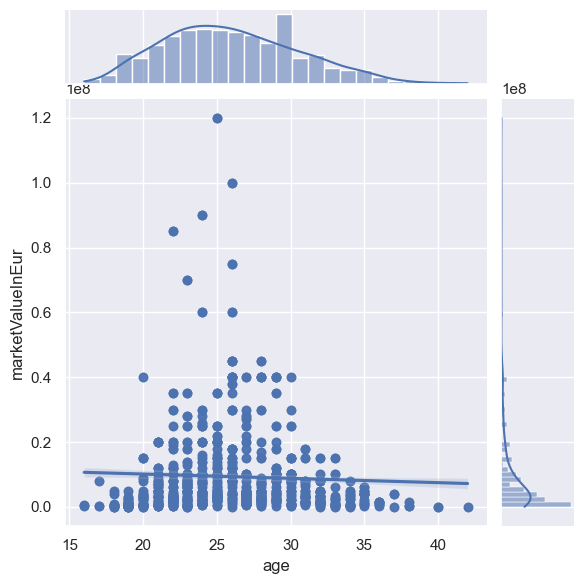

In [70]:
sns.jointplot(data=players_df, x='age', y='marketValueInEur', kind='reg')

Ci siamo chiesti come fossero distribuiti i giocatori in base alla loro eta' e il loro valore di mercato.

# Valore dei giocatori in base all'età

In [71]:
age_value_df = players_df[['age', 'marketValueInEur']]
age_value_df = age_value_df.dropna()

# Aggregate by age while calculating mean market value
avg_value_by_age = age_value_df.groupby('age')['marketValueInEur'].mean().reset_index()

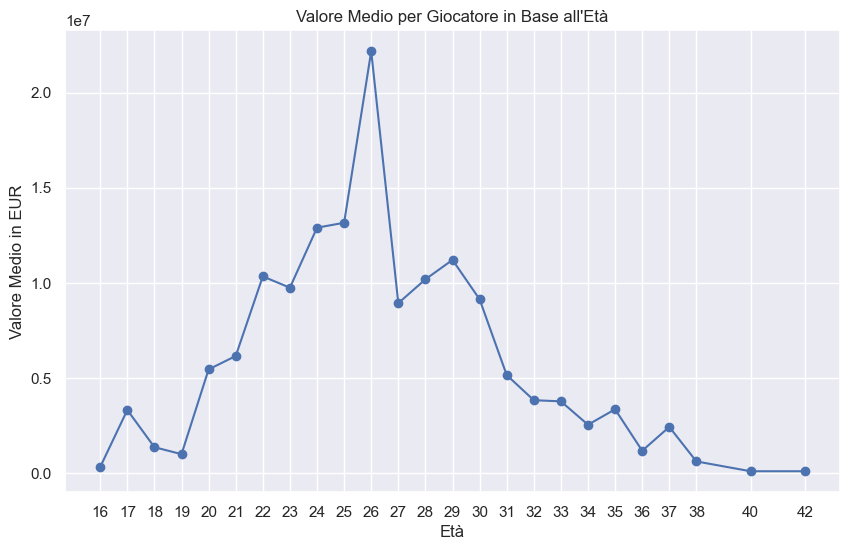

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(avg_value_by_age['age'], avg_value_by_age['marketValueInEur'], marker='o', linestyle='-', color='b')

plt.xticks(avg_value_by_age['age'])

plt.title('Valore Medio per Giocatore in Base all\'Età')
plt.xlabel('Età')
plt.ylabel('Valore Medio in EUR')

plt.grid(True)
plt.show()

Andiamo ora a vedere in dettaglio il valore medio dei giocatori in relazione alla loro eta'.


# Goal medi per partita in base all'età

In [73]:
# Fetch all players with role = "Attack" and join the dataset with the appearance dataset
attaccanti = players_df.query('position == "Attack"')
player_age = attaccanti[['age', 'id', 'marketValueInEur']]
appearances_df['date'] = pd.to_datetime(appearances_df['date'])

In [74]:
# Get only last year's appearances to get the correct age / performance relationship
last_year_appearances_player_df = appearances_df.query("date.dt.year == 2023")
last_year_appearances_player_df = last_year_appearances_player_df.join(player_age.set_index('id'), rsuffix='_player', on='player_id')
last_year_appearances_player_df = last_year_appearances_player_df.dropna()
last_year_appearances_player_df.reset_index(inplace=True)
last_year_appearances_player_df

,index,appearance_id,game_id,player_id,date,player_name,yellow_cards,red_cards,goals,assists,minutes_played,age,marketValueInEur
0,2,4171291_257462,4171291,257462,2023-11-28 00:00:00+00:00,Luka Jović,0,0,0,0,13,26.0,8000000.0
1,2,4171291_257462,4171291,257462,2023-11-28 00:00:00+00:00,Luka Jović,0,0,0,0,13,26.0,8000000.0
2,2,4171291_257462,4171291,257462,2023-11-28 00:00:00+00:00,Luka Jović,0,0,0,0,13,26.0,8000000.0
3,6,4171291_315779,4171291,315779,2023-11-28 00:00:00+00:00,Christian Pulisic,0,0,0,0,90,25.0,25000000.0
4,6,4171291_315779,4171291,315779,2023-11-28 00:00:00+00:00,Christian Pulisic,0,0,0,0,90,25.0,25000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,33909,3844888_405885,3844888,405885,2023-01-04 00:00:00+00:00,Giacomo Raspadori,0,0,0,0,25,23.0,35000000.0
2765,33909,3844888_405885,3844888,405885,2023-01-04 00:00:00+00:00,Giacomo Raspadori,0,0,0,0,25,23.0,35000000.0
2766,33910,3844888_502670,3844888,502670,2023-01-04 00:00:00+00:00,Khvicha Kvaratskhelia,0,0,0,0,76,22.0,85000000.0
2767,33910,3844888_502670,3844888,502670,2023-01-04 00:00:00+00:00,Khvicha Kvaratskhelia,0,0,0,0,76,22.0,85000000.0


In [75]:
# Appearance dataset contains "goals" value. Group by age and calculate the average amount of goals per player age
players_goal_age = last_year_appearances_player_df[['goals', 'age']]
players_goal_age = players_goal_age.dropna()
avg_players_goal_age = players_goal_age.groupby('age')['goals'].mean().reset_index()

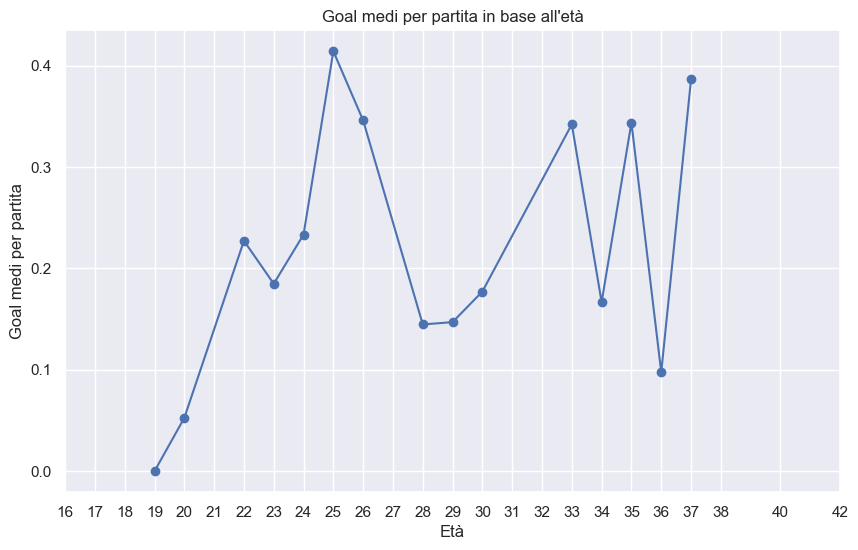

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(avg_players_goal_age['age'], avg_players_goal_age['goals'], marker='o', linestyle='-', color='b')

plt.xticks(avg_value_by_age['age'])

plt.title('Goal medi per partita in base all\'età')
plt.xlabel('Età')
plt.ylabel('Goal medi per partita')

plt.grid(True)
plt.show()

Passiamo ora ad analizzare la performance dei giocatori in relazione alla loro eta'. Non avendo altre metriche utili alla valutazione della performance, utilizziamo in il numero di goal segnati in media per partita, percio' analizzeremo solo gli attaccanti.

# Confronto tra goal e valore in base all'età

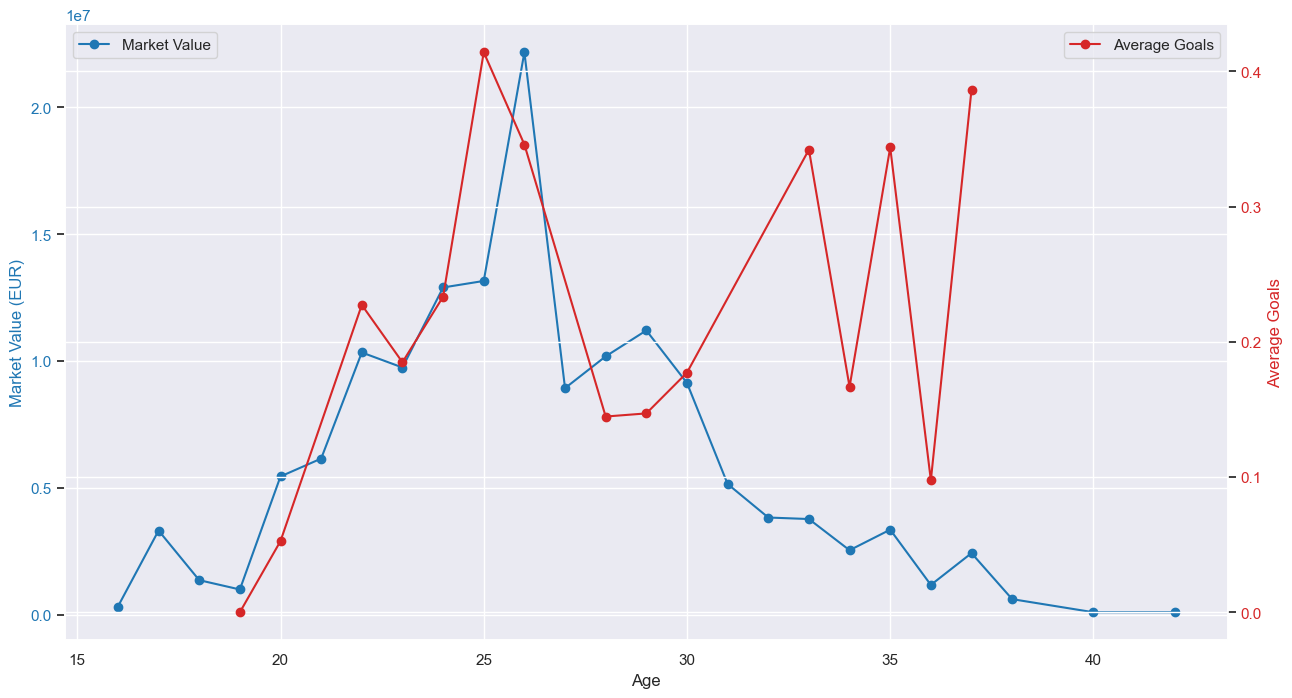

In [77]:
# Create figure canvas
fig, ax1 = plt.subplots(figsize=(15, 8))

# Create MarketValue / Age line plot
ax1.set_xlabel('Age')
ax1.set_ylabel('Market Value (EUR)', color='tab:blue')
ax1.plot(avg_value_by_age['age'], avg_value_by_age['marketValueInEur'], marker='o', color='tab:blue', label='Market Value')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create MarketValue / Age line plot
ax2 = ax1.twinx()
ax2.set_ylabel('Average Goals', color='tab:red')
ax2.plot(avg_players_goal_age['age'], avg_players_goal_age['goals'], marker='o', color='tab:red', label='Average Goals')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.legend()
plt.show()

Confrontiamo come il numero di goal medi per partita e il valore di mercato dei giocatori cambia per gruppo di eta'.

# Correlazione tra valore e goal medi per partita

<Axes: xlabel='goals', ylabel='marketValueInEur'>

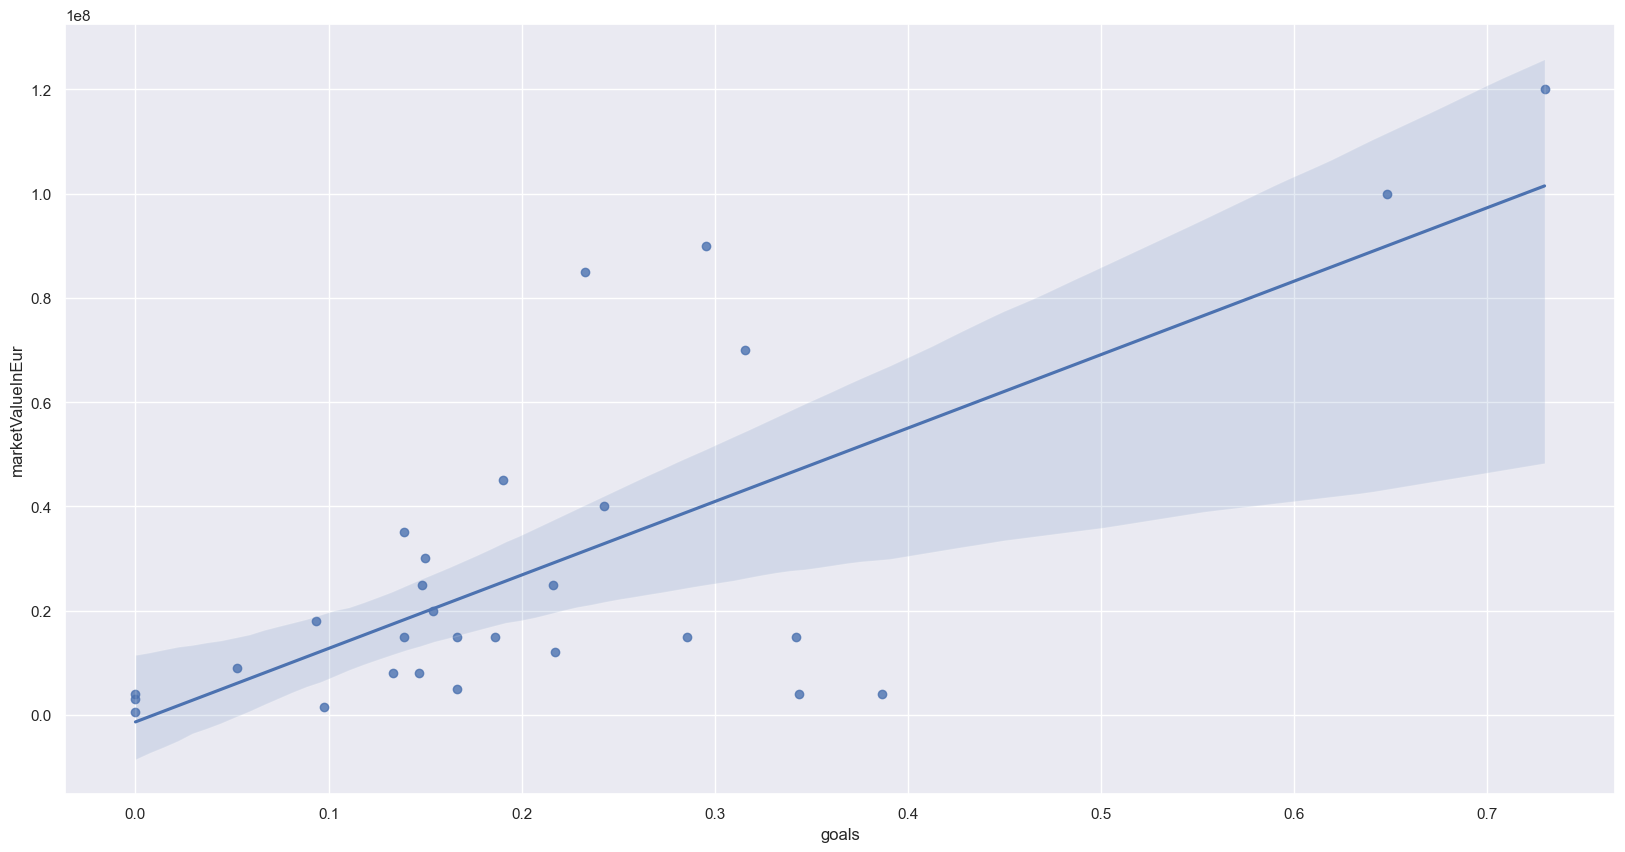

In [78]:
# Aggregate the appearances of each player, calculating the average amount of goals per match
player_goal_value = last_year_appearances_player_df[['player_id', 'marketValueInEur', 'goals']]
avg_player_goal_value = player_goal_value.groupby('player_id').agg({
    'goals': 'mean',
    'marketValueInEur': 'mean'
}).reset_index()

sns.set(rc={'figure.figsize':(20,10)})
sns.regplot(data=avg_player_goal_value, x='goals', y='marketValueInEur')

Analizziamo ora se il numero di goal medi per partita di un giocatore influenza il suo valore di mercato.

# Valore medio per posizione di giocatori locali e stranieri

<Axes: xlabel='position', ylabel='marketValueInEur'>

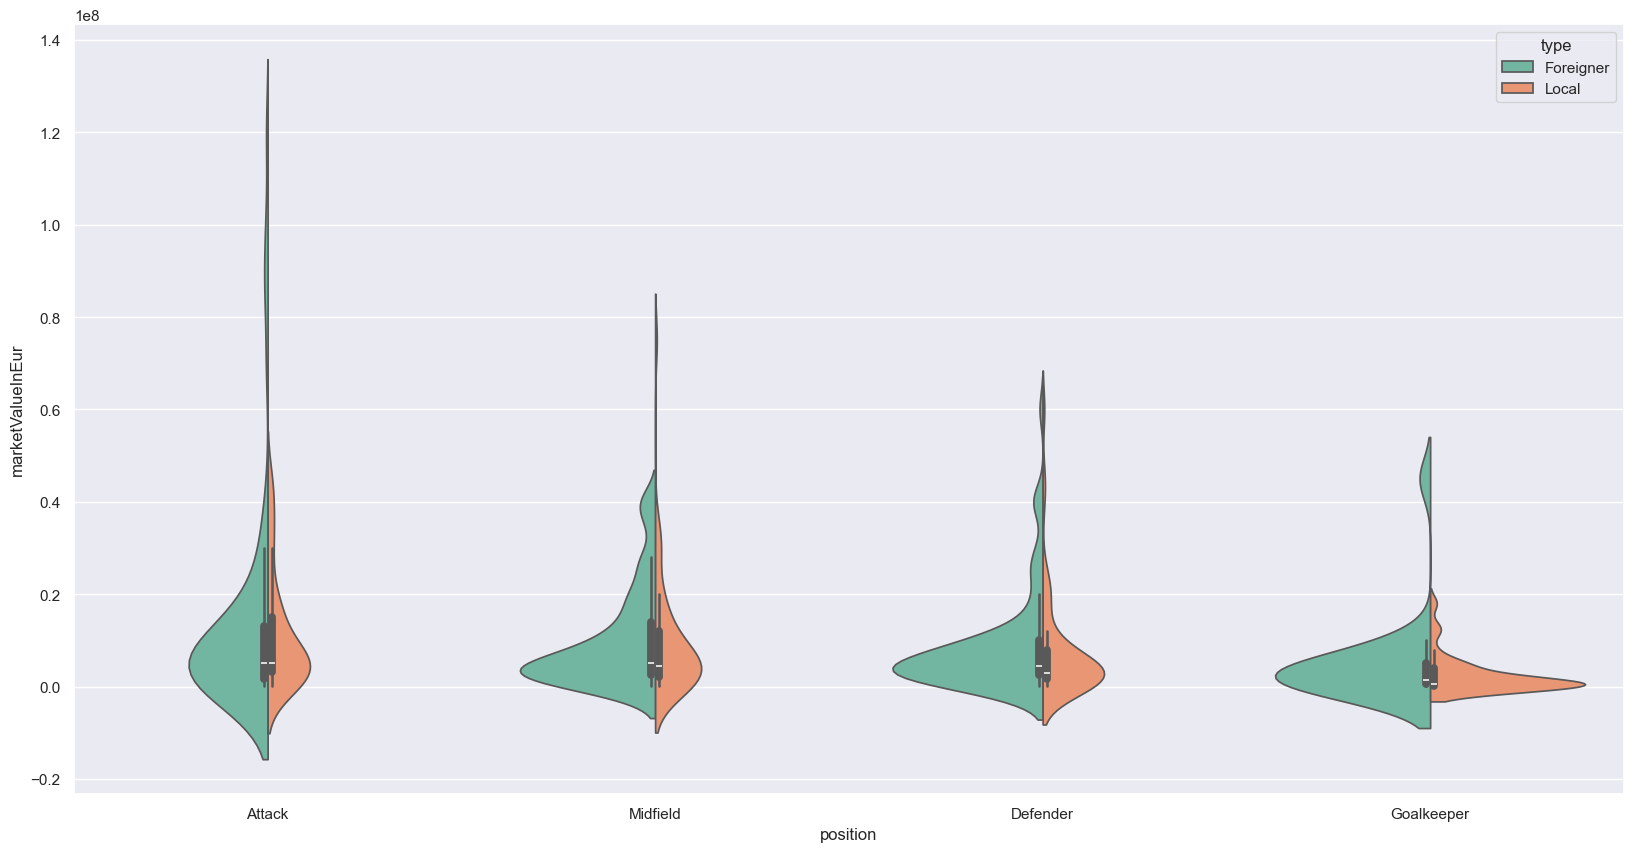

In [79]:
sns.set(rc={'figure.figsize':(20,10)})
sns.violinplot(x='position', y='marketValueInEur', data=players_df, palette='Set2', hue='type', split=True)

Infine vediamo se c'è differenza tra il valore di mercato dei giocatori stranieri e locali e ne confrontiamo la distribuzione e range per ogni posizione.